In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os 
#os.mkdir("./gdrive/MyDrive/RL_PA2_Mcar")
os.chdir("./gdrive/MyDrive/RL_PA2_Mcar")

Mounted at /content/gdrive


In [2]:

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
#from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [3]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=10000, n_hidden2=8000):
        super(ActorCriticModel, self).__init__()
        self.model_name=self.__class__.__name__ 
        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        self.fc3=tf.keras.layers.Dropout(0.4)
        self.fc4=tf.keras.layers.BatchNormalization()
        self.fc5 = tf.keras.layers.Dense(5000, activation='relu')
        self.fc6=tf.keras.layers.BatchNormalization()
        self.fc7=tf.keras.layers.Dropout(0.4)
        self.fc8 = tf.keras.layers.Dense(2048, activation='relu')
        self.fc9=tf.keras.layers.BatchNormalization()
        self.fc10=tf.keras.layers.Dropout(0.4)
        self.fc11 = tf.keras.layers.Dense(512, activation='relu')
        self.fc12=tf.keras.layers.BatchNormalization()
        self.fc13=tf.keras.layers.Dropout(0.4)
        self.fc14 = tf.keras.layers.Dense(128, activation='relu')
        self.fc15=tf.keras.layers.BatchNormalization()
        self.fc16=tf.keras.layers.Dropout(0.4)
        
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)
        layer2 = self.fc3(layer2)
        layer2 = self.fc4(layer2)
        layer2 = self.fc5(layer2)
        layer2 = self.fc6(layer2)
        layer2 = self.fc7(layer2)
        layer2 = self.fc8(layer2)
        layer2 = self.fc9(layer2)
        layer2 = self.fc10(layer2)
        layer2 = self.fc11(layer2)
        layer2 = self.fc12(layer2)
        layer2 = self.fc13(layer2)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

In [4]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=1024, n_hidden2=512):
        super(ActorCriticModel, self).__init__()
        self.model_name=self.__class__.__name__ 
        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

In [5]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
        self.agent_name=self.ac_model.model_name
        
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state=None, done=False,n=1,full_return=False):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        if full_return:
          with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            

            V_s = tf.squeeze(V_s)
            delta=reward-V_s

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

          gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
          self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))


        else:
          with tf.GradientTape(persistent=True) as tape:
              pi, V_s = self.ac_model(state)
              _, V_s_next = self.ac_model(next_state)
              #loss_c =huber_loss(reward + (((self.gamma)**n)*(V_s_next*(1))),V_s)
              V_s = tf.squeeze(V_s)
              V_s_next = tf.squeeze(V_s_next)
              

              #### TO DO: Write the equation for delta (TD error)
              ## Write code below
              delta = reward + (((self.gamma)**n)*(V_s_next*(1-int(done)))) - V_s
              if full_return:
                delta=reward-V_s

              loss_a = self.actor_loss(action, pi, delta)
              loss_c =self.critic_loss(delta)
              loss_total = loss_a + loss_c

          gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
          gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
          self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))


In [10]:

def step_variance_plots(reward_variation,step_variation,title="ad"):
  reward_variation=np.array(reward_variation)
  mean=np.mean(reward_variation, axis=0)
  mean_st=np.mean(step_variation)
  var = np.sqrt((np.sum((reward_variation-mean)**2,axis=0)))/runs
  print(step_variation)


  plt.figure(figsize=(8,8))
  plt.plot([i+1 for i in range(mean.shape[0])],mean)
  plt.plot([i+1 for i in range(mean.shape[0])],[reward_threshold for i in range(mean.shape[0])])
  plt.title(f"Reward Plot+(Avg_steps_to_comp={mean_st})")
  plt.suptitle(title)
  plt.xlabel("Episodes")
  plt.ylabel("Avgerage reward over 10 runs")
  plt.savefig(f"./Reward_plot {title}.jpg")



  plt.figure(figsize=(8,8))
  plt.plot([i+1 for i in range(mean.shape[0])],var)
  plt.title("Variance")
  plt.suptitle(title)
  plt.xlabel("Episodes")
  plt.ylabel("Avg Variance over 10 runs")
  plt.savefig(f"./Var_{title}.jpg")

def discounted_reward(rewards,gamma=0.99):
  sum=0 
  g=1 

  for i in range(rewards.shape[0]):
    sum+=(rewards[i]*g)
    g=g*gamma 
  return sum.astype(np.float32)


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward -200.000000 Average Reward nan No of steps 200.000000
Episode  10 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  20 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  30 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  40 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  50 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  60 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  70 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  80 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  90 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  100 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  110 Reward -200.000000 Average Reward -200.000000 No of steps 200.000000
Episode  120 Reward -200.000000 Ave

AttributeError: ignored

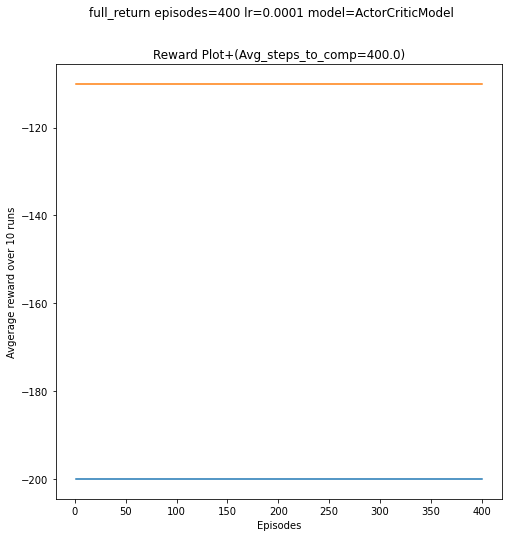

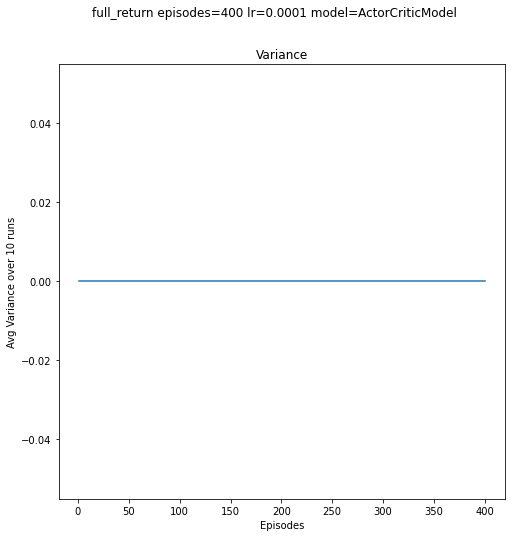

In [11]:
env = gym.make('MountainCar-v0')
reward_threshold=env.spec.reward_threshold
reward_variations={"One_step":[1],"n-step":[4,16]}
reward_variations={"full_return":[1]}
learning_rate_parameters=[1e-4]
episode_parameters=[400]
runs=1


for variation in reward_variations.keys():
  for n in reward_variations[variation]:
    for epi in episode_parameters:
      for lr in learning_rate_parameters:
            reward_variation=[]
            no_of_steps_list=[epi for i in range(runs)]
            for run in range(runs):
              state_shape = env.observation_space.shape[0]
              action_shape = env.action_space.n
              #Initializing Agent
              agent = Agent(lr=lr, action_size=env.action_space.n)
              #Number of episodes
              episodes = epi
              tf.compat.v1.reset_default_graph()

              reward_list = [reward_threshold for i in range(episodes)]
              average_reward_list = []
              
              begin_time = datetime.datetime.now()
                
              for ep in range( episodes):
                
                  avg_100 =  np.mean(reward_list[max(0,ep-20):ep])
                  if avg_100 > reward_threshold:
                      print('Stopped at Episode ',ep-20)
                      no_of_steps_list[run]=ep-20+1
                      break
                  state = env.reset().reshape(1,-1)
                  done = False
                  ep_rew = 0 
                  no_of_steps=0
                  
                  if variation=="One_step":
                    var_title=variation
                    while not done:
                      action = agent.sample_action(state) ##Sample Action
                      next_state, reward, done, info = env.step(action) ##Take action
                      next_state = next_state.reshape(1,-1)
                      ep_rew += reward  ##Updating episode reward
                      agent.learn(state, action, reward, next_state, done) ##Update Parameters
                      state = next_state ##Updating State
                      no_of_steps+=1 
                  elif variation=="full_return":
                      var_title=variation
                      curr_rew=0 
                      gam=1 
                      action_array=[]
                      state_array=[]
                      reward_array=[]
                      while not done:
                        action = agent.sample_action(state) ##Sample Action
                        next_state, reward, done, info = env.step(action) ##Take action
                        action_array.append(action)
                        state_array.append(state) 
                        reward_array.append(reward)
                        next_state = next_state.reshape(1,-1)
                        ep_rew += reward  ##Updating episode reward
                  
        
                        state = next_state ##Updating State
                        no_of_steps+=1 
                      for i in range(len(action_array)):
                        state=state_array[i]
                        curr_rew=discounted_reward(np.array(reward_array[i:]))
                        action=action_array[i]
                        agent.learn(state, action, curr_rew, next_state, done,full_return=True)
                  else: 
                      var_title=f"{n}_step_return"
                      while not done:
                        curr_rew=0 
                        gam=1
                        for i in range(n):
                          
                          
                          action = agent.sample_action(state) ##Sample Action
                          next_state, reward, done, info = env.step(action) ##Take action
                          
                          next_state = next_state.reshape(1,-1)
                          if done:
                            break 
                          curr_rew+=(reward*gam)
                          gam=gam*agent.gamma
                          ep_rew += reward 
                          no_of_steps+=1 
                          prev_state=state
                          state = next_state
                        agent.learn(prev_state, action, curr_rew, state, done,n=n)
                        

                      
                  
                  
                  reward_list[ep]=(ep_rew)
                  
                  if ep % 10 == 0:
                    print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_100,"No of steps %f" %no_of_steps)
                  
              reward_variation.append(np.array(reward_list))
              time_taken = datetime.datetime.now() - begin_time
              print(time_taken)
              if no_of_steps_list[run]==0:
                no_of_steps_list[run]=ep+1
            title=f"{var_title} episodes={epi} lr={lr} model={agent.agent_name}"
            step_variance_plots(reward_variation,no_of_steps_list,title)
